# Prêt à dépenser : Construire un modèle de scoring


## Contexte

"Prêt à dépenser" (Home Credit) est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.
Pour accorder un crédit à la consommation, l'entreprise calcule la probabilité qu'un client le rembourse, ou non. Elle souhaite donc développer un algorithme de scoring pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs du modèle de scoring. Puisqu'ils s'adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d'une mesure de l'importance des variables qui ont poussé le modèle à donner cette probabilité à un client.


## Chargement des modules du projet

Afin de simplifier le Notebook, le code métier du projet est placé dans le répertoire [src/](../src/).


In [1]:
# Import project modules from source directory

# Import system modules
import os
import sys

# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)


import data.helpers as data_helpers
import visualization.helpers as vis_helpers


Nous allons utiliser le langage [Python](https://www.python.org/about/gettingstarted/), et présenter ici le code, les résultats et l'analyse sous forme de [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html).

Nous allons aussi utiliser les bibliothèques usuelles d'exploration et analyse de données, afin d'améliorer la simplicité et la performance de notre code :
  * [NumPy](https://numpy.org/doc/stable/user/quickstart.html) et [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : effectuer des calculs scientifiques (statistiques, algèbre, ...) et manipuler des séries et tableaux de données volumineuses et complexes
  * [scikit-learn](https://scikit-learn.org/stable/getting_started.html) et [XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html) : pour effectuer des analyses prédictives 
  * [Matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html), [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html), [Seaborn](https://seaborn.pydata.org/tutorial/function_overview.html) et [Plotly](https://plotly.com/python/getting-started/) : générer des graphiques lisibles, intéractifs et pertinents


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
import sklearn as sk
import xgboost as xgb

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Prevent excessive memory usage used by plotly
DRAW_PLOTS: bool = True


## Chargement des données

Les données mises à disposition sont issues de [Home Credit](https://www.homecredit.net/) et plus précisément de la compétition hébergée sur Kaggle [Home Credit Default Risk - Can you predict how capable each applicant is of repaying a loan?](https://www.kaggle.com/c/home-credit-default-risk)

Les données sont fournies sous la forme de plusieurs fichiers CSV pouvant être liés entre eux de la manière suivante :

![Home Credit data relations](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

_source : [Introduction: Home Credit Default Risk Competition](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) by [Will Koehrsen](https://www.kaggle.com/willkoehrsen)_


In [3]:
# Download and extract the raw data
data_helpers.download_extract_zip(
    zip_file_url="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip",
    files_names=(
        "application_test.csv",
        "application_train.csv",
        "bureau_balance.csv",
        "bureau.csv",
        "credit_card_balance.csv",
        "installments_payments.csv",
        "POS_CASH_balance.csv",
        "previous_application.csv",
    ),
    target_path="../data/raw/",
)


### Application

Nous allons charger toutes les données des fichiers `application_{train|test}.csv` dans le même DataFrame, afin de travailler les données en commun des jeux d'entraînement (variable `TARGET` vaut `O` : le client n'a pas fait défaut ou `1` : le client a fait défaut) et de test(variable `TARGET` non définie). Nous les séparerons à nouveau au moment de l'entrainement et évaluation de nos modèles.


#### Préparation des données : vérifications et définition du bon type de chaque variable

Les fichiers contiennent un grand nombre de variables booléennes et categorielles que nous pouvons déjà typer comme telles.

In [4]:
# Read column names
application_train_column_names = pd.read_csv(
    "../data/processed/application_train.csv", nrows=0
).columns.values
application_test_column_names = pd.read_csv(
    "../data/processed/application_test.csv", nrows=0
).columns.values

# TARGET variable must be present in the Train datase
if "TARGET" not in application_train_column_names:
    raise ValueError(
        "TARGET column not found in application_train.csv. Please check that the file is not corrupted."
    )

# SK_ID_CURR variable must be present in the Train datase
if "SK_ID_CURR" not in application_train_column_names:
    raise ValueError(
        "SK_ID_CURR column not found in application_train_column_names.csv. Please check that the file is not corrupted."
    )

# Train and Test datasets must have the same variables, except for the TARGET variable
if list(
    application_train_column_names[application_train_column_names != "TARGET"]
) != list(application_test_column_names):
    raise ValueError(
        "Column names in application_train.csv and application_test.csv do not match. Please check that the files are not corrupted."
    )

# Set column types according to fields description (../data/raw/HomeCredit_columns_description.csv)
# Categorical variables
column_types = {
    col: "category"
    for col in application_train_column_names
    if col.startswith(("NAME_",))
    or col.endswith(("_TYPE"))
    or col
    in [
        "TARGET",
        "CODE_GENDER",
        "WEEKDAY_APPR_PROCESS_START",
        "FONDKAPREMONT_MODE",
        "HOUSETYPE_MODE",
        "WALLSMATERIAL_MODE",
        "EMERGENCYSTATE_MODE",
    ]
}
# Boolean variables
column_types |= {
    col: bool
    for col in application_train_column_names
    if col.startswith(("FLAG_", "REG_", "LIVE_"))
}

# Load application data
app_train_df = pd.read_csv(
    "../data/processed/application_train.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"],
)
app_test_df = pd.read_csv(
    "../data/processed/application_test.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"], # bad values
)

# Merge Train and Test datasets
app_df = app_train_df.append(app_test_df)

# Let's display basic statistical info about the data
app_df.describe(include="all")


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,307511,356255,356251,356255,356255,356255.000000,3.562550e+05,3.562550e+05,356219.000000,...,356255,356255,356255,356255,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
unique,NaN,2,2,2,2,2,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,0,Cash loans,F,False,True,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,282686,326537,235126,235235,246970,NaN,NaN,NaN,NaN,...,353679,356072,356099,356152,NaN,NaN,NaN,NaN,NaN,NaN
mean,278128.000000,NaN,NaN,NaN,NaN,NaN,0.414316,1.701161e+05,5.877674e+05,27425.560657,...,NaN,NaN,NaN,NaN,0.005808,0.006281,0.029995,0.231697,0.304399,1.911564
std,102842.104413,NaN,NaN,NaN,NaN,NaN,0.720378,2.235068e+05,3.986237e+05,14732.808190,...,NaN,NaN,NaN,NaN,0.079736,0.104250,0.191374,0.855949,0.786915,1.865338
min,100001.000000,NaN,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189064.500000,NaN,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278128.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367191.500000,NaN,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


#### Analyse exploratoire des données

Nous allons analyser la distribution de quelques variables.

##### Variable cible

Voyons spécifiquement la distribution de la variable `TARGET` qui est celle que nous devrons estimer par la suite.
Les valeurs nulles représentent notre jeu d'entrainement.
Nous pouvons oberver que nous avons à faire à un problème de __classification binaire déséquilibré__ (il y a deux valeurs possibles, mais les deux valeurs ne sont pas également représentées).
Ceci va influencer la manière dont nous allons construire et entraîner notre modèle.


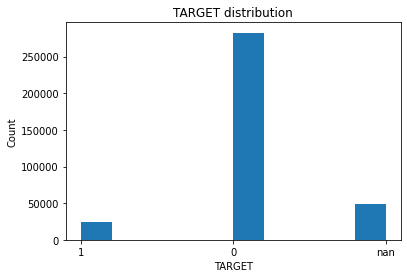

In [6]:
# Display TARGET distribution
plt.hist(list(app_df["TARGET"]))
plt.title("TARGET distribution")
plt.xlabel("TARGET")
plt.ylabel("Count")
plt.show()


##### Valeurs vides

Nous voyons que toutes les variables ont moins de 30% de valeurs vides, et près de la moitié a moins de 1% de valeurs vides. Le jeu de données est donc relativement bien rempli, ce qui ne devrait pas poser de problème pour la suite.


In [7]:
# Let's display variables with missing values ratio
if DRAW_PLOTS:
    vis_helpers.plot_empty_values(app_df)


##### Valeurs vides

Nous voyons que toutes les variables ont moins de 30% de valeurs vides, et près de la moitié a moins de 1% de valeurs vides. Le jeu de données est donc relativement bien rempli, ce qui ne devrait pas poser de problème pour la suite.


---

# Annexe

Les Notebooks Kaggle [Introduction: Home Credit Default Risk Competition](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) (et suivants) de [Will Koehrsen](https://www.kaggle.com/willkoehrsen) ont été d'une très grande aide dans l'exploration des données.
